# Import

0 : Latch:_LA_269353054_DevicePositionXOnLFAtP1;_CEID15651.4
1 : Latch:_LA_269353055_DevicePositionYOnLFAtP1;_CEID15651.5
2 : Latch:_LA_269353094_DispenseProcessAvePress;_CEID15651.7
3 : Latch:_LA_269353095_DispenseProcessAveZHeight;_CEID15651.8
4 : Latch:_LA_251920580_DispenserPressure_ECRO;_CEID15651.9
5 : Latch:_LA_269353101_PickProcessAvePickForce;_CEID15653.7
6 : Latch:_LA_269353102_PickProcessAveNeedleTopHeight;_CEID15653.8
7 : Latch:_LA_269353097_BondProcessAveBondForce;_CEID15652.6
8 : Latch:_LA_269353098_BondProcessAveBondZHeight;_CEID15652.7
9 : Latch:_LA_269353069_DiePlacementOnStripX;_CEID15652.11
10 : Latch:_LA_269353070_DiePlacementOnStripY;_CEID15652.12
11 : Latch:_LA_269353071_DiePlacementOnStripTheta;_CEID15652.13
12 : Sig:_BondProcess_PBIDiePlacementOnStripTheta_(post_Step)
13 : Sig:_BondProcess_PBIDiePlacementOnStripX_uM_(post_Step)
14 : Sig:_BondProcess_PBIDiePlacementOnStripY_uM_(post_Step)
15 : DataID


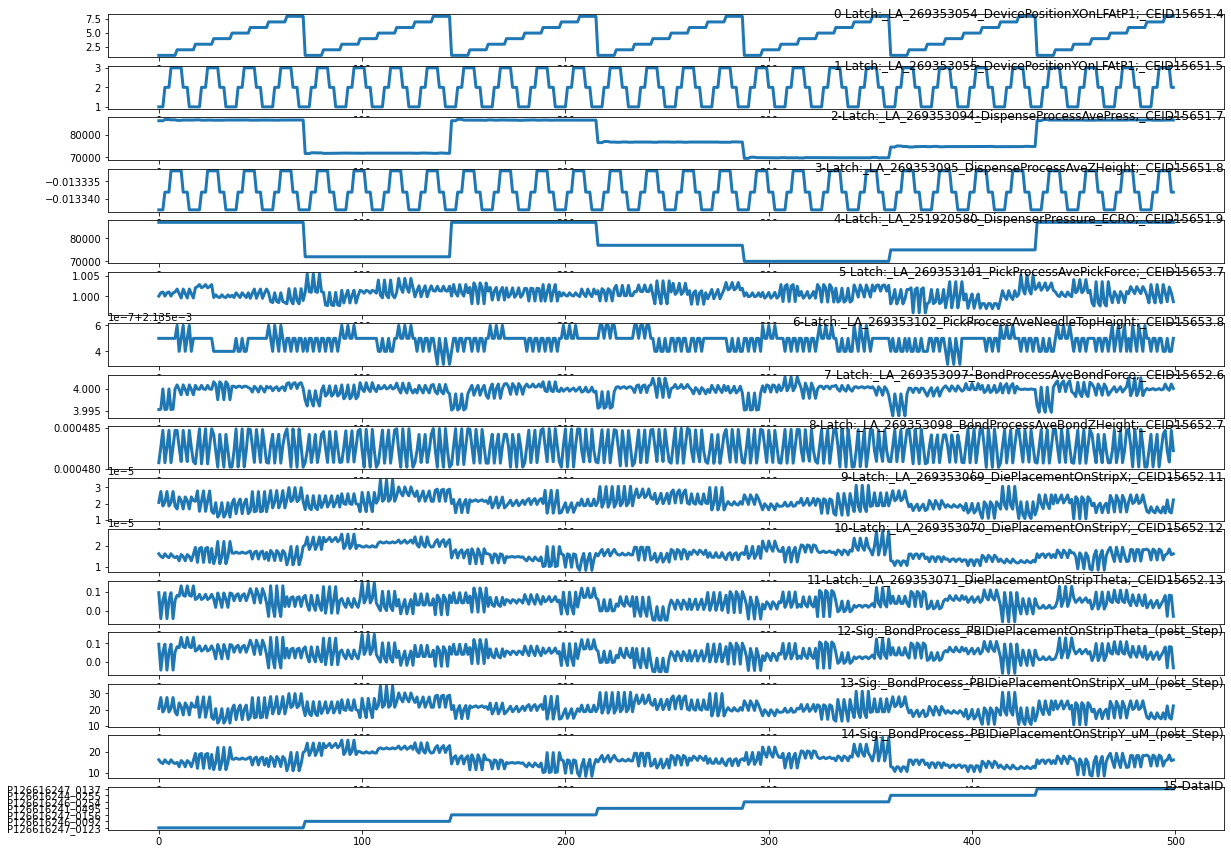

In [1]:
# Import the libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import seaborn as sns
import math
import json,os
from IPython.core.pylabtools import figsize
FDC_path = r"E:\FDC\dataset"
figsize(10,10) 
#FDC_Data = pd.read_csv(r'E:\FDC\dataset\data2021.csv', sep=',')

import data_vis as dv
import importlib
importlib.reload(dv)




FDC_2021Data = dv.read_data(os.path.join(FDC_path,'data_all_exclude_miss.csv'))
Y_LIST = [1,2,3,4,5,19,20,22,23,26,27,28,35,36,37,44]

X_LIST = dv.find_coi(FDC_2021Data,Y_LIST)
FDC_2021Data = FDC_2021Data.drop(FDC_2021Data.iloc[:,X_LIST],axis=1)
dv.df_col_map(FDC_2021Data)

import data_vis as dv
import importlib
importlib.reload(dv)

dv.draw_trend(FDC_2021Data,groups=range(FDC_2021Data.shape[1]),bound=500)

In [2]:
def scatterPlot(x,y,df,color,colorName="quality", a=0.65, main_title=""):
    df=df.copy()
    df[f"{colorName}"]=color
    #plt.figure(figsize=(12,9))

    s=sns.JointGrid(
        x=x, 
        y=y, 
        data=df, 
        hue=f"{colorName}",
        palette="viridis",
        height=10,
        ratio=5
        )
    s.plot_joint(sns.scatterplot, s=100, alpha=a)
    s.plot_marginals(sns.kdeplot, cut=0)
    s.fig.suptitle(main_title, fontsize=15)
    
    ax = plt.gca()
    #ax.set_title(main_title)

# Split Data

In [21]:
data = np.array(FDC_2021Data.iloc[:,12:15])
targets = np.array(FDC_2021Data.iloc[:,0])
from sklearn.preprocessing import MinMaxScaler,RobustScaler

scaler = MinMaxScaler((0,1))
X_scaled = scaler.fit_transform(data)
print(X_scaled.shape)
print(targets.shape)

(975673, 3)
(975673,)


In [22]:
from sklearn.ensemble import IsolationForest as ISOF
cnt = 240
isoForest=ISOF(random_state=0,verbose=1)
isoForest.fit(X_scaled[:cnt,:])

dFunc = isoForest.decision_function(X_scaled[cnt:cnt*2,:])
Is_outvalue = isoForest.predict(X_scaled[cnt:cnt*2,:])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [23]:
np.savetxt("anomaly_score3.csv", dFunc, delimiter=",")
#np.savetxt("outvalue1.csv", Is_outvalue, delimiter=",")

In [24]:
FDC_2021Data.columns[5:-4]
FDC_2021Data.columns[12:15]

Index(['Sig:_BondProcess_PBIDiePlacementOnStripTheta_(post_Step)',
       'Sig:_BondProcess_PBIDiePlacementOnStripX_uM_(post_Step)',
       'Sig:_BondProcess_PBIDiePlacementOnStripY_uM_(post_Step)'],
      dtype='object')

In [14]:
dFunc.shape

(975433,)

In [11]:
for sig in FDC_2021Data.columns[12:15]:
    for latch in FDC_2021Data.columns[5:-4]:
        scatterPlot(
            x=latch,
            y=sig,
            df=FDC_2021Data.iloc[cnt:,:],
            color=["yes" if i < -0.15 else "No" for i in dFunc],
            colorName="outlier",
            main_title="Isolation Forest Outlier Yes or No",
            a=0.8
            )

ValueError: array must not contain infs or NaNs

Error in callback <function flush_figures at 0x000001CBE9D27B80> (for post_execute):


KeyboardInterrupt: 

# Dimension Reduciton

In [37]:
from sklearn import manifold


X_tsne = manifold.TSNE(n_components=3, init='random', random_state=5, verbose=1,perplexity=100,n_iter=1000).fit_transform(X_scaled[:24000])

print(X_tsne.shape)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne-x_min) / (x_max-x_min)  #Normalize


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24000 samples in 0.020s...
[t-SNE] Computed neighbors for 24000 samples in 1.425s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24000
[t-SNE] Computed conditional probabilities for sample 2000 / 24000
[t-SNE] Computed conditional probabilities for sample 3000 / 24000
[t-SNE] Computed conditional probabilities for sample 4000 / 24000
[t-SNE] Computed conditional probabilities for sample 5000 / 24000
[t-SNE] Computed conditional probabilities for sample 6000 / 24000
[t-SNE] Computed conditional probabilities for sample 7000 / 24000
[t-SNE] Computed conditional probabilities for sample 8000 / 24000
[t-SNE] Computed conditional probabilities for sample 9000 / 24000
[t-SNE] Computed conditional probabilities for sample 10000 / 24000
[t-SNE] Computed conditional probabilities for sample 11000 / 24000
[t-SNE] Computed conditional probabilities for sample 12000 / 24000
[t-SNE] Computed conditional probabilities for sa

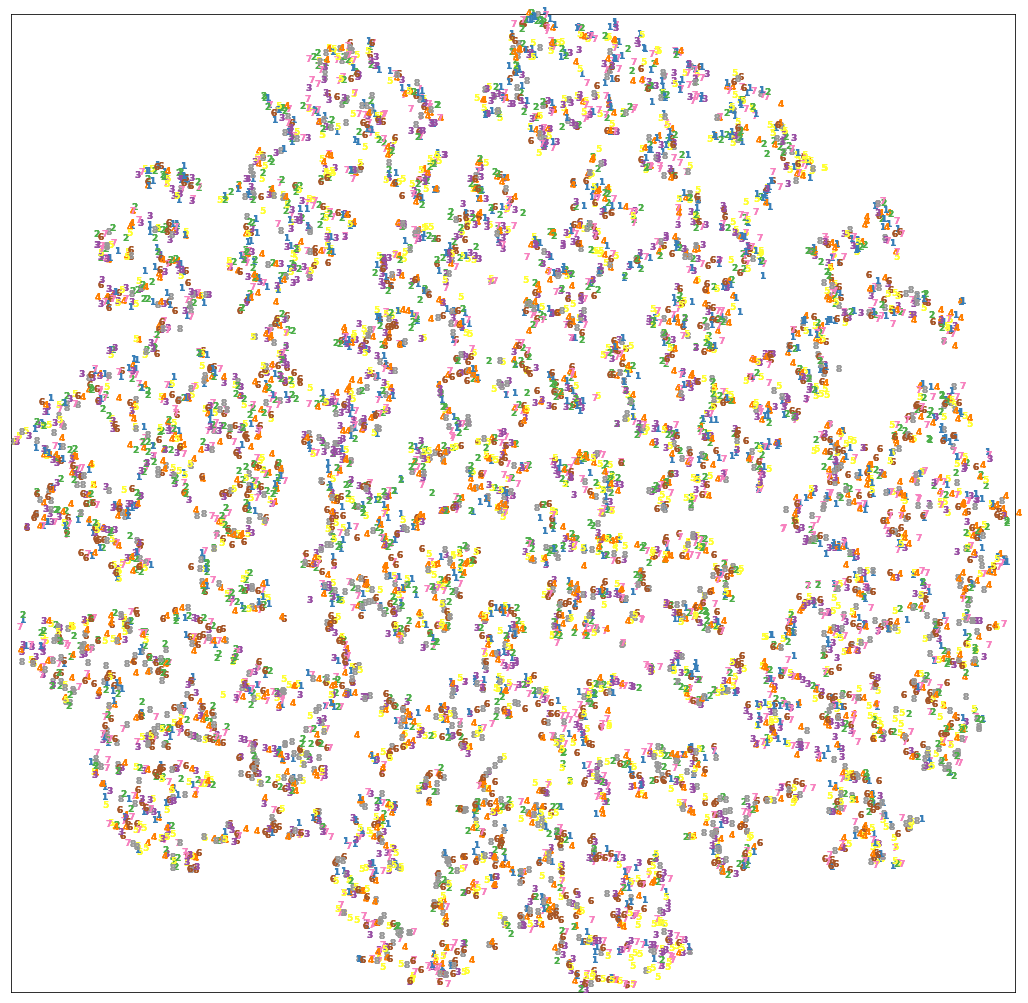

In [36]:
plt.figure(figsize=(18,18))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(targets[i]), color=plt.cm.Set1(targets[i]), 
             fontdict={"weight": "bold", "size": 9})
plt.xticks([])
plt.yticks([])
plt.show()

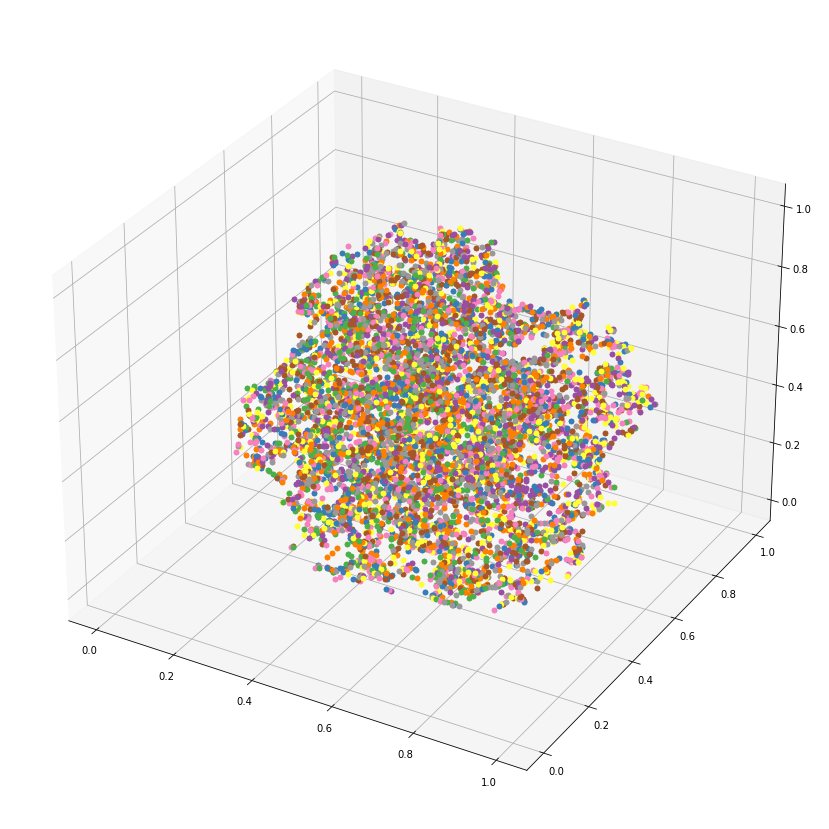

In [38]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line

zdata = X_norm[:,2]
xdata = X_norm[:,0]
ydata = X_norm[:,1]

for i in range(X_norm.shape[0]):
    ax.scatter3D(X_norm[i,0],X_norm[i,1],X_norm[i,2] , color=plt.cm.Set1(targets[i]));



In [ ]:
# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

# Other

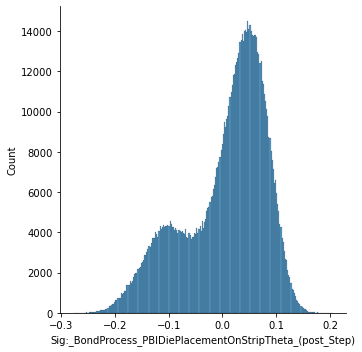

In [40]:
import seaborn as sns
sns.displot(FDC_2021Data.iloc[:,19])

In [2]:
Upper_boundary_limit = FDC_2021Data.iloc[:,19].mean() + 3* FDC_2021Data.iloc[:,19].std()
Lower_boundary_limit = FDC_2021Data.iloc[:,19].mean() - 3* FDC_2021Data.iloc[:,19].std()
print(Upper_boundary_limit,Lower_boundary_limit)

FDC_2021Data["PBIDiePlacementOnStripTheta_class"] = \
   FDC_2021Data.iloc[:,19].apply(lambda x: 1 if x < Lower_boundary_limit or x > Upper_boundary_limit else 0)





FDC_2021Data

0.23356917789636783 -0.22230530692104106


,Latch:_LA_269353054_DevicePositionXOnLFAtP1;_CEID15651.4,Latch:_LA_269353055_DevicePositionYOnLFAtP1;_CEID15651.5,Latch:_LA_269353094_DispenseProcessAvePress;_CEID15651.7,Latch:_LA_269353095_DispenseProcessAveZHeight;_CEID15651.8,Latch:_LA_251920580_DispenserPressure_ECRO;_CEID15651.9,Latch:_LA_251920465_DispenseHeightToStrip_ECRO;_CEID15651.10,Latch:_LA_269353065_PostbondEpoxyCoverageCheckData;_CEID15652.10,Latch:_LA_269353101_PickProcessAvePickForce;_CEID15653.7,Latch:_LA_269353102_PickProcessAveNeedleTopHeight;_CEID15653.8,Sig:_BondProcess_PBIEpoxyCoverage_(post_Step),...,Latch:_LA_252314736_BondDistanceToBondPosition_ECRO;_CEID15652.9,Latch:_LA_269353069_DiePlacementOnStripX;_CEID15652.11,Latch:_LA_269353070_DiePlacementOnStripY;_CEID15652.12,Latch:_LA_269353071_DiePlacementOnStripTheta;_CEID15652.13,Latch:_LA_252313626_PickForceD180_ECRO;_CEID15653.9,Latch:_LA_252313630_PickNeedleTopHeight_ECRO;_CEID15653.10,Sig:_BondProcess_PBIDiePlacementOnStripTheta_(post_Step),Sig:_BondProcess_PBIDiePlacementOnStripX_uM_(post_Step),Sig:_BondProcess_PBIDiePlacementOnStripY_uM_(post_Step),PBIDiePlacementOnStripTheta_class
0,1,1,86432,-0.013343,87000,0.00013,-99.99,1.00010,0.002135,-1.000000e+250,...,-0.0002,0.000021,0.000016,0.095361,1.0,0.0004,0.095361,20.804,16.1220,0
1,1,1,86432,-0.013343,87000,0.00013,-99.99,1.00090,0.002135,-1.000000e+250,...,-0.0002,0.000028,0.000015,-0.041286,1.0,0.0004,-0.041286,27.526,14.9000,0
2,1,1,86432,-0.013343,87000,0.00013,-99.99,1.00110,0.002135,-1.000000e+250,...,-0.0002,0.000019,0.000014,0.055199,1.0,0.0004,0.055199,18.622,14.3410,0
3,1,2,86972,-0.013338,87000,0.00013,-99.99,1.00010,0.002135,-1.000000e+250,...,-0.0002,0.000021,0.000016,0.095361,1.0,0.0004,0.095361,20.804,16.1220,0
4,1,2,86972,-0.013338,87000,0.00013,-99.99,1.00090,0.002135,-1.000000e+250,...,-0.0002,0.000028,0.000015,-0.041286,1.0,0.0004,-0.041286,27.526,14.9000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975668,8,2,101660,-0.013095,102000,0.00013,-99.99,1.00150,0.002133,-1.000000e+250,...,-0.0002,0.000025,0.000009,-0.101410,1.0,0.0004,-0.101410,24.857,9.3241,0
975669,8,2,101660,-0.013095,102000,0.00013,-99.99,0.99919,0.002133,-1.000000e+250,...,-0.0002,0.000017,0.000009,-0.131240,1.0,0.0004,-0.131240,17.083,9.2742,0
975670,8,1,101710,-0.013104,102000,0.00013,-99.99,0.99981,0.002133,-1.000000e+250,...,-0.0002,0.000023,0.000004,-0.092818,1.0,0.0004,-0.092818,22.472,4.0172,0
975671,8,1,101710,-0.013104,102000,0.00013,-99.99,1.00150,0.002133,-1.000000e+250,...,-0.0002,0.000025,0.000009,-0.101410,1.0,0.0004,-0.101410,24.857,9.3241,0


In [19]:
FDC_2021Data['PBIDiePlacementOnStripTheta_class'].value_counts(normalize=True)

0    0.998988
1    0.001012
Name: PBIDiePlacementOnStripTheta_class, dtype: float64

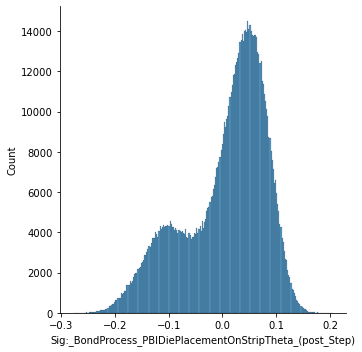

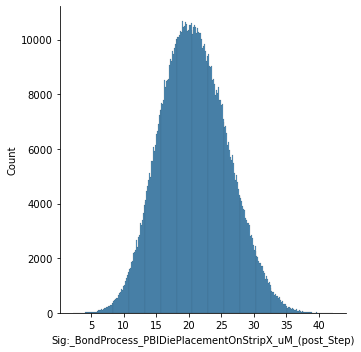

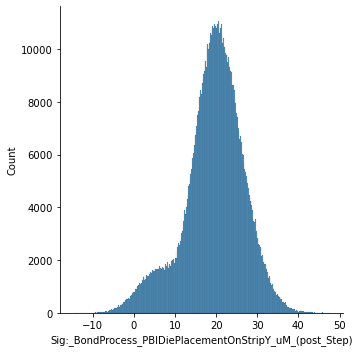

In [3]:
import seaborn as sns
sns.displot(FDC_2021Data.iloc[:,19])
sns.displot(FDC_2021Data.iloc[:,20])
sns.displot(FDC_2021Data.iloc[:,21])

In [31]:
plt.figure(figsize=(10,10))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(targets[i]), color=plt.cm.Set1(targets[i]), 
             fontdict={"weight": "bold", "size": 9})
plt.xticks([])
plt.yticks([])
plt.savefig("./images/TSNC_plot/test.png")
plt.close()

In [34]:
from sklearn import manifold

for perplexity in [20,70,80,90]:
    
    X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=0,perplexity=perplexity,n_iter=5000).fit_transform(X_scaled[:24*1000])


    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne-x_min) / (x_max-x_min)  #Normalize


    plt.figure(figsize=(10,10))
    for i in range(X_norm.shape[0]):
        plt.text(X_norm[i, 0], X_norm[i, 1], str(targets[i]), color=plt.cm.Set1(targets[i]), 
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([])
    plt.yticks([])
    plt.savefig("./images/TSNC_plot/perplexity_{}.png".format(perplexity))
    plt.close()
    print(">Step {} done!!".format(perplexity))

KeyboardInterrupt: 